# Get Area-Elevation Curve

In [1]:
import geopandas as gpd
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### select the reservoir

In [2]:
start_date = '2023-07-21'
end_date = '2025-10-30'
RESERVOIR = 8

ALG_TYPE = 'tmsos'
DATA_DIR = Path('/tiger1/pdas47/resorr-swot/data/tennesse/basins/cumberland/gee/gee_sarea_tmsos')

Cordell_Hull_Dam


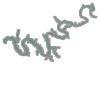

In [3]:
reservoir_boundaries = gpd.read_file(Path('/tiger1/pdas47/resorr-swot/data/cumberland-reservoirs/03-cumberland-reservoirs.geojson'))

selected_reservoirs = reservoir_boundaries['id'].tolist()
res_names = reservoir_boundaries[['id', 'name']].set_index('id').to_dict()['name']

RESERVOIR_NAME = res_names[RESERVOIR]
RESERVOIR_GDF = reservoir_boundaries[reservoir_boundaries['id'] == RESERVOIR]
RESERVOIR_GEOMETRY = RESERVOIR_GDF.geometry.iloc[0]

# get reservoir properties from GRanD
nominal_area = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_SKM'].values[0]
nominal_area_poly = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_POLY'].values[0]
max_area = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_MAX'].values[0]
max_area = np.nan if max_area == -99 else max_area

min_area = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_MIN'].values[0]
min_area = 0 if min_area == -99 else min_area

area_rep = RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['AREA_REP'].values[0]
dam_height = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['DAM_HGT_M'].values[0])
elev_msl = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['ELEV_MASL'].values[0])
depth = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['DEPTH_M'].values[0])
capacity = float(RESERVOIR_GDF[RESERVOIR_GDF['id'] == RESERVOIR]['CAP_MCM'].values[0])

print(RESERVOIR_NAME)

RESERVOIR_GEOMETRY

## Storage Calculation

In [4]:
aec_dir = Path('/tiger1/pdas47/resorr-swot/data/aec/srtm_area_sat_aev')

In [5]:
aec_fp = aec_dir / f'{RESERVOIR}.csv'
if not aec_fp.exists():
    aec_fp = aec_dir / f'{RESERVOIR_NAME}.csv'

aec_df = pd.read_csv(aec_fp, comment='#')

# if using RAT AECs, convert the names of columns
if 'CumArea' in aec_df.columns:
    aec_df.rename({'CumArea': 'Area'}, inplace=True, axis=1)
    aec_df.drop('Elevation_Observed', inplace=True, axis=1)
    aec_df['Storage (mil. m3)'] = aec_df['Storage (mil. m3)'] * 1e6  # convert to m³

aec_df

,Area,Elevation,Storage,Storage (mil. m3)
0,0.000,143.924484,0.000000e+00,0.000000e+00
1,0.250,143.963873,4.923620e+03,4.923620e+03
2,0.500,144.003369,1.970783e+04,1.970783e+04
3,0.750,144.042972,4.437934e+04,4.437934e+04
4,1.000,144.082681,7.896485e+04,7.896485e+04
...,...,...,...,...
381,92.000,165.632785,8.876794e+08,8.876794e+08
382,92.250,165.711483,8.931164e+08,8.931164e+08
383,92.500,165.790288,8.985730e+08,8.985730e+08
384,92.750,165.869199,9.040493e+08,9.040493e+08


# Calculate storage using insitu aev.

In [18]:
import xarray as xr
import numpy as np
import difflib

# inp_dir = Path('/tiger1/pdas47/tmsosPP/data/storage/icesat2/2324-insitu')
inp_dir = Path('/tiger1/pdas47/resorr-swot/data/USA/basins/cumberland/gee/gee_sarea_tmsos')

# fuzzy match for tmsos data files
if ALG_TYPE == 'tmsos':
    files = inp_dir.glob("*.csv")
    scores = []
    for fp in files:
        stem = fp.stem
        # remove leading numeric ID if present (e.g. "1752.0_Barkley_Dam" -> "Barkley_Dam")
        parts = stem.split('_')
        if parts and any(ch.isdigit() for ch in parts[0]):
            cleaned = '_'.join(parts[1:]) or stem
        else:
            cleaned = stem

        r1 = difflib.SequenceMatcher(None, RESERVOIR_NAME.lower(), stem.lower()).ratio()
        r2 = difflib.SequenceMatcher(None, RESERVOIR_NAME.lower(), cleaned.lower()).ratio()
        score = max(r1, r2)
        scores.append((fp, stem, cleaned, score))

    best_fp, best_stem, best_clean, best_score = max(scores, key=lambda x: x[3])
    selected = best_fp
    print(f"selected: {selected} (score={best_score:.3f}, stem='{best_stem}', cleaned='{best_clean}')")
    fp = best_fp
    
    data = {
        'area': [],
        'date': [],
    }

    df = pd.read_csv(fp, parse_dates=['date'])

    # filter
    df = df[df['QUALITY_DESCRIPTION']<1]
    
    data['area'] = df['area']
    data['date'] = df['date']
    data['storage'] = np.interp(data['area'], aec_df['Area'], aec_df['Storage (mil. m3)'])

else:
    fp = inp_dir / f'{RESERVOIR}.csv'

    data = {
        'elevation': [],
        'date': [],
    }
    
    df = pd.read_csv(fp, parse_dates=['time'])

    data['elevation'] = df['elevation']
    data['date'] = df['time']
    data['storage'] = np.interp(data['elevation'], aec_df['Elevation'], aec_df['Storage (mil. m3)'])

reservoir_dynamics = pd.DataFrame(data)
reservoir_dynamics = reservoir_dynamics.dropna()
reservoir_dynamics['storage_change'] = reservoir_dynamics['storage'].diff()
reservoir_dynamics['delta_t'] = reservoir_dynamics['date'].diff().dt.days
reservoir_dynamics

selected: /tiger1/pdas47/resorr-swot/data/USA/basins/cumberland/gee/gee_sarea_tmsos/7318.0_Cordell_Hull_Dam.csv (score=1.000, stem='7318.0_Cordell_Hull_Dam', cleaned='Cordell_Hull_Dam')


,area,date,storage,storage_change,delta_t
0,36.835432,2022-06-06,1.209833e+08,NaN,NaN
1,36.835432,2022-06-11,1.209833e+08,0.000000e+00,5.0
2,38.285539,2022-06-16,1.313010e+08,1.031766e+07,5.0
3,35.779153,2022-06-18,1.137584e+08,-1.754264e+07,2.0
4,39.105869,2022-06-21,1.373461e+08,2.358775e+07,3.0
...,...,...,...,...,...
364,38.885385,2025-10-08,1.357068e+08,0.000000e+00,5.0
365,38.885385,2025-10-13,1.357068e+08,0.000000e+00,5.0
366,38.885385,2025-10-18,1.357068e+08,0.000000e+00,5.0
367,38.885385,2025-10-23,1.357068e+08,0.000000e+00,5.0


383500000.0


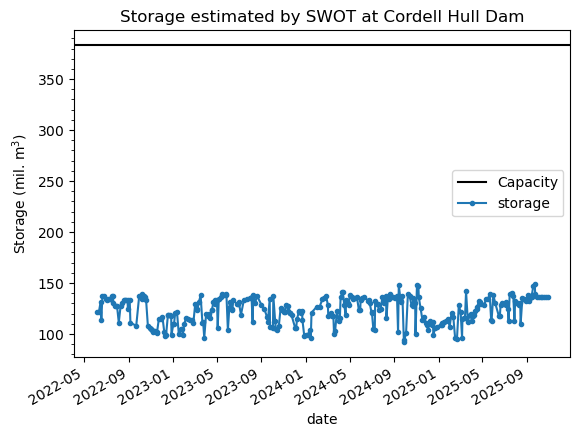

In [19]:
from matplotlib import ticker

print(capacity * 1e6)

f, ax = plt.subplots()

if RESERVOIR_NAME == 'Old_Hickory_Dam':
    PERMANENT_POOL_VOL = 440352360
    PONDAGE_ALLOWED_FOR_POWER = 77709240
    SURCHARGE_FLOOD_STORE_VOL = 154185000

    ax.axhline(PERMANENT_POOL_VOL + PONDAGE_ALLOWED_FOR_POWER + SURCHARGE_FLOOD_STORE_VOL, color='lightgreen', label='Flood surcharge storage')
    ax.axhline(PERMANENT_POOL_VOL + PONDAGE_ALLOWED_FOR_POWER, color='Olive', label='Pondage allowed for power')
    ax.axhline(PERMANENT_POOL_VOL, color='Green', label='Permanent Pool')
else:
    ax.axhline(capacity * 1e6, label='Capacity', color='black')


reservoir_dynamics.plot(
    ax=ax,
    x='date',
    y='storage',
    marker='.'
)

ax.ticklabel_format(axis='y', style='sci', scilimits=(6, 6), useOffset=False, useMathText=True)

offset_text_artist = ax.yaxis.get_offset_text()
offset_text_artist.set_visible(False) # removing the x10^6 from plot. Specifying the unit in label.
ax.set_ylabel('Storage (mil. m$^3$)')

ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_title(f'Storage estimated by SWOT at {RESERVOIR_NAME.replace("_", " ")}')

ax.legend()

In [20]:
save_fn = Path(f'/tiger1/pdas47/resorr-swot/data/storage/tmsos_srtm_aev/{RESERVOIR}.csv')
save_fn.parent.mkdir(exist_ok=True)
reservoir_dynamics.to_csv(save_fn, index=False)